In [3]:
# Import necessary libraries
import pandas as pd

# Load the dataset from the CSV file (replace with your actual file path)
file_path = 'inventory_data_large.csv'
inventory_data = pd.read_csv(file_path)

# Convert the Date column to datetime and sort the data by date
inventory_data['Date'] = pd.to_datetime(inventory_data['Date'])
inventory_data = inventory_data.sort_values('Date')

# Check the structure of the data
print(inventory_data.info())
print(inventory_data.head())


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 330 to 730
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1000 non-null   datetime64[ns]
 1   Day                1000 non-null   object        
 2   Month              1000 non-null   object        
 3   Location           1000 non-null   object        
 4   Ingredient         1000 non-null   object        
 5   Starting_Quantity  1000 non-null   float64       
 6   Purchased          1000 non-null   float64       
 7   Consumption        1000 non-null   float64       
 8   Ending_Quantity    1000 non-null   float64       
 9   Status             1000 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 85.9+ KB
None
          Date       Day   Month   Location      Ingredient  \
330 2018-01-03    Sunday  31-Aug  Vancouver  Chicken Breast   
593 2018-01-03  Saturday  11-May  

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# We will focus on the 'Consumption' column as the feature and 'Ending_Quantity' as the target.
# Dropping any irrelevant columns for this model
inventory_data = inventory_data[['Date', 'Consumption', 'Ending_Quantity']]

# Scaling the data for LSTM (LSTM works better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(inventory_data[['Consumption', 'Ending_Quantity']])

# Preparing the time-series data (windowed data) for LSTM
def create_sequences(data, time_steps=30):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i+time_steps, 0])  # input (Consumption)
        labels.append(data[i+time_steps, 1])  # output (Ending_Quantity)
    return np.array(sequences), np.array(labels)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

# Reshaping X to be suitable for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")


Training data shape: (776, 30, 1), Test data shape: (194, 30, 1)


In [5]:
# Importing necessary libraries for building the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Building the LSTM model
model = Sequential()

# Adding the LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))  # Predicting Ending_Quantity

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Summarizing the model
model.summary()


Epoch 1/20


C:\Users\Moi\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1360 - val_loss: 0.0450
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0468 - val_loss: 0.0427
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0461 - val_loss: 0.0429
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0435 - val_loss: 0.0424
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0441 - val_loss: 0.0428
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0442 - val_loss: 0.0430
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0442 - val_loss: 0.0422
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0439 - val_loss: 0.0429
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0473 - val_loss: 0.0427
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0450 - val_loss: 0.0422
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0399 - val_l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
MAE: 215.13902982986073
RMSE: 260.3701453715626


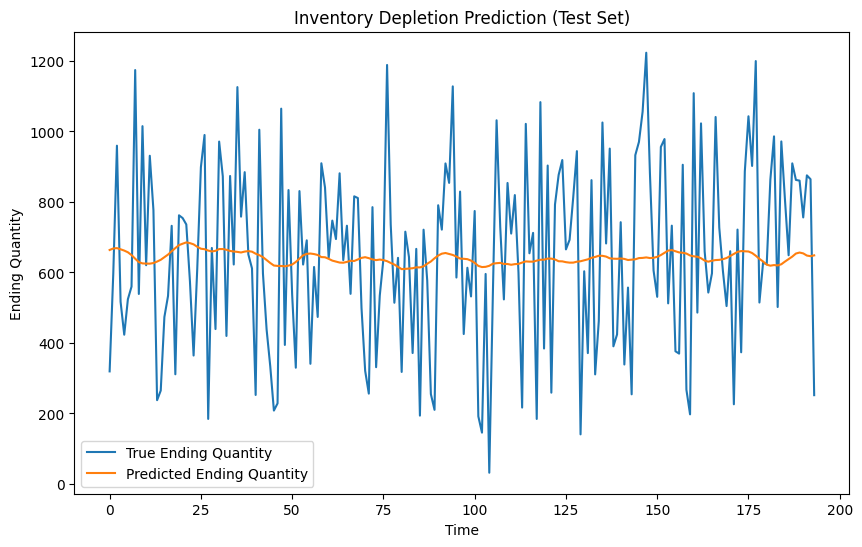

In [6]:
# Evaluate the model on the test set
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the test set
predicted_endings = model.predict(X_test)

# Inverse scaling to get original values
predicted_endings_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], predicted_endings), axis=1))[:, 1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, 1]

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test_rescaled, predicted_endings_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_endings_rescaled))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Ending Quantity')
plt.plot(predicted_endings_rescaled, label='Predicted Ending Quantity')
plt.title('Inventory Depletion Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Ending Quantity')
plt.legend()
plt.show()


In [7]:
# Predict 
last_30_days = scaled_data[-30:, 0].reshape(1, 30, 1)
predicted_future = model.predict(last_30_days)

# Rescaling to original values
predicted_future_rescaled = scaler.inverse_transform([[0, predicted_future[0, 0]]])[0][1]
print(f"Predicted Ending Quantity for the future: {predicted_future_rescaled}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Ending Quantity for the future: 652.4185571785861


In [26]:
# Save the scaler and model
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
model.save("inventory_model.h5")

# Alternative Model Development - Multilayer Perceptron Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

C:\Users\Moi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Moi\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the dataset
file_path = 'inventory_data_large.csv'
inventory_data = pd.read_csv(file_path)

# Convert the Date column to datetime and sort the data by date
inventory_data['Date'] = pd.to_datetime(inventory_data['Date'])
inventory_data = inventory_data.sort_values('Date')

# Focus on the 'Consumption' and 'Ending_Quantity' columns for the model
inventory_data = inventory_data[['Date', 'Consumption', 'Ending_Quantity']]

In [3]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(inventory_data[['Consumption', 'Ending_Quantity']])

# Prepare the time-series data (windowed data) for the MLP
def create_sequences(data, time_steps=30):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i+time_steps, 0])  # input (Consumption)
        labels.append(data[i+time_steps, 1])  # output (Ending_Quantity)
    return np.array(sequences), np.array(labels)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

# Reshaping X to be suitable for MLP input: (samples, time_steps) (MLP doesn't require the 3D shape)
X = np.reshape(X, (X.shape[0], X.shape[1]))

In [4]:
# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the MLP model
model_mlp = Sequential()

# Adding layers for MLP (using Flatten since MLP expects a flat input rather than time series)
model_mlp.add(Flatten(input_shape=(time_steps,)))
model_mlp.add(Dense(units=64, activation='relu'))
model_mlp.add(Dense(units=32, activation='relu'))
model_mlp.add(Dense(units=1))  # Predicting Ending_Quantity

# Compile the model
model_mlp.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Moi\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train the model
history_mlp = model_mlp.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the MLP model on the test set
predicted_endings_mlp = model_mlp.predict(X_test)

# Inverse scaling to get original values
predicted_endings_rescaled_mlp = scaler.inverse_transform(np.concatenate((X_test[:, -1].reshape(-1, 1), predicted_endings_mlp), axis=1))[:, 1]
y_test_rescaled_mlp = scaler.inverse_transform(np.concatenate((X_test[:, -1].reshape(-1, 1), y_test.reshape(-1, 1)), axis=1))[:, 1]

# Calculating MAE and RMSE
mae_mlp = mean_absolute_error(y_test_rescaled_mlp, predicted_endings_rescaled_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test_rescaled_mlp, predicted_endings_rescaled_mlp))

print(f"MLP Model MAE: {mae_mlp}")
print(f"MLP Model RMSE: {rmse_mlp}")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1015 - val_loss: 0.0673
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0499 - val_loss: 0.0601
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0482 - val_loss: 0.0587
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0455 - val_loss: 0.0566
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0413 - val_loss: 0.0545
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411 - val_loss: 0.0523
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0430 - val_loss: 0.0548
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0427 - val_loss: 0.0505
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0417 - val_loss: 0.0502
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388 - val_loss: 0.0502
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362 - val_loss: 0.0503
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0364 - val_lo

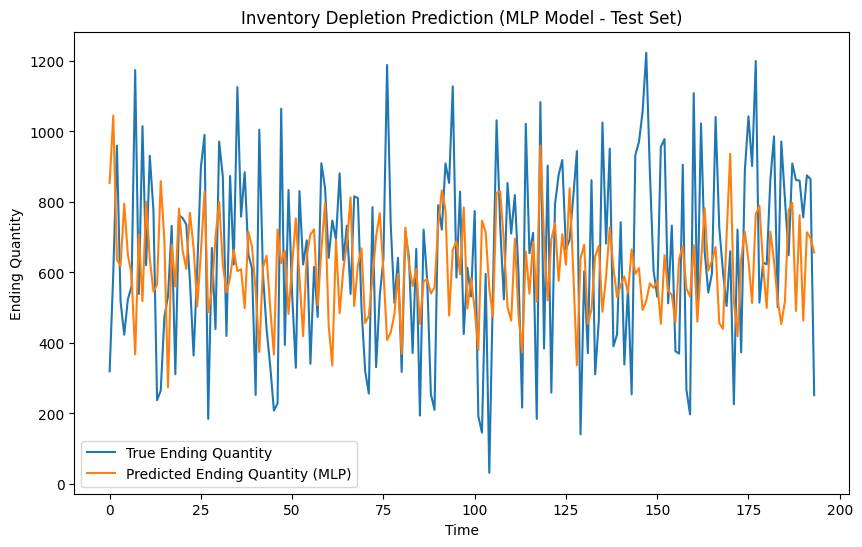

In [6]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled_mlp, label='True Ending Quantity')
plt.plot(predicted_endings_rescaled_mlp, label='Predicted Ending Quantity (MLP)')
plt.title('Inventory Depletion Prediction (MLP Model - Test Set)')
plt.xlabel('Time')
plt.ylabel('Ending Quantity')
plt.legend()
plt.show()